### Option Pricing
In computational finance and risk management, several numerical methods e.g. finite differences, Fourier methods and Monte
Carlo simulation are commonly used for the valuation of financial
derivatives and also in modern risk management. 

In the context of financial derivative pricing, there is a stage in which the asset model needs to be calibrated to market data. In other words, the open parameters in the asset price model
need to be fitted. This is typically not done by historical asset prices, but by means of option prices, i.e. by
matching the market prices of heavily traded options to the option prices from the mathematical model,
under the so-called risk-neutral probability measure. In the case of model calibration, thousands of
option prices need to be determined in order to fit these asset parameters. However, due to the
requirement of a highly efficient computation, certain high quality asset models are discarded. Efficient
numerical computation is also increasingly important in financial risk management, especially when
we deal with real-time risk management (e.g., high frequency trading) or counterparty credit risk
issues, where a trade-off between efficiency and accuracy seems often inevitable and this is where machine learning can be useful.

In this case study we look at the derivative pricing from a machine learning standpoint. The focus of this case study are as follow:

* Developing Machine Learning based framework for Derivative pricing. 

* Intuition behind the models and comparison of Linear vs. Non Linear models in the context of detivative pricing. 

* Things to be careful about when using Machine Learning based models for derivatives price. 

* Comparison of machine learning methods vs. the conventional numerical methods.


## Content

* [1. Introduction](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Defining function and parameters](#1.2)
    * [2.3. Load Dataset](#1.3)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation and analysis](#3)
    * [4.1.Feature Selection](#3.1) 
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split and evaluation metrics](#4.1)
    * [5.2. Compare Models and Algorithms](#4.2)
* [6. Model Tuning and finalizing the model](#5)
* [7. Additional analysis: removing the volatilty data](#6)


<a id='0'></a>
# 1. Introduction

Options have been used in finance as means to hedge risk in a nonlinear manner. They are are also used by speculators in order to take leveraged bets in the financial markets. Historically, people have used the Black Scholes formula.

$$  Se^{-q \tau}\Phi(d_1) - e^{-r \tau} K\Phi(d_2) \, $$

With

$$  d_1 = \frac{\ln(S/K) + (r - q + \sigma^2/2)\tau}{\sigma\sqrt{\tau}}  $$

and

$$  d_2 = \frac{\ln(S/K) + (r - q - \sigma^2/2)\tau}{\sigma\sqrt{\tau}} = d_1 - \sigma\sqrt{\tau}  $$

Where we have;
    Stock price $S$;
    Strike price $K$;
    Risk-free rate $r$;
    Annual dividend yield $q$;
    Time to maturity $\tau = T-t$ (represented as a unit-less fraction of one year);
    Volatility $\sigma$

In order to make the logic simpler, we define *Moneyness* as $M = K/S$ and look at the prices in terms of per unit of current stock price. We also set $q$ as $0$ 

This simplifes the formula down to the following

$$  e^{-q \tau}\Phi\left( \frac{- \ln(M) + (r+ \sigma^2/2 )\tau}{\sigma\sqrt{\tau}}\right) - e^{-r \tau} M\Phi\left( \frac{- \ln(M) + (r - \sigma^2/2)\tau}{\sigma\sqrt{\tau}} \right) \, $$

### Vol Suface

In the options market, there isn't a single value of volatility which gives us the correct price. We often find the volatility such that the output matches the price

### Simulation

In this exercise, we assume the the sturcture of the vol surface. In practice, we would source the data from a data vendor.

We use the following function to generate the option volatility surface

$$ \sigma(M, \tau) = \sigma_0 + \alpha\tau + \beta (M - 1)^2$$

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

### Python Imports

In [42]:
# Distribution functions
from scipy.stats import norm


# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf


In [43]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
## 2.2. Defining functions and parameters

### True Parameters

In [44]:
true_alpha = 0.1
true_beta = 0.1
true_sigma0 = 0.2

In [45]:
risk_free_rate = 0.05

### Vol and Option Pricing Functions

In [46]:
def option_vol_from_surface(moneyness, time_to_maturity):
    return true_sigma0 + true_alpha * time_to_maturity + true_beta * np.square(moneyness - 1)

def call_option_price(moneyness, time_to_maturity, option_vol):
    d1=(np.log(1/moneyness)+(risk_free_rate+np.square(option_vol))*time_to_maturity)/(option_vol*np.sqrt(time_to_maturity))
    d2=(np.log(1/moneyness)+(risk_free_rate-np.square(option_vol))*time_to_maturity)/(option_vol*np.sqrt(time_to_maturity))
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    
    return N_d1 - moneyness * np.exp(-risk_free_rate*time_to_maturity) * N_d2

<a id='1.3'></a>
## 2.3. Data Generation

In [57]:
N = 10000

Ks = 1+0.25*np.random.randn(N)
Ts = np.random.random(N)
Sigmas = np.array([option_vol_from_surface(k,t) for k,t in zip(Ks,Ts)])
Ps = np.array([call_option_price(k,t,sig) for k,t,sig in zip(Ks,Ts,Sigmas)])

### Set the Endog and Exog Data

In [58]:
Y = Ps

X = np.concatenate([Ks.reshape(-1,1), Ts.reshape(-1,1), Sigmas.reshape(-1,1)], axis=1)

dataset = pd.DataFrame(np.concatenate([Y.reshape(-1,1), X], axis=1),
                       columns=['Price', 'Strike', 'Time', 'Vol'])

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [59]:
dataset.head()

,Price,Strike,Time,Vol
0,1.390e-01,0.898,0.221,0.223
1,3.814e-06,1.223,0.052,0.210
2,1.409e-01,0.969,0.391,0.239
3,1.984e-01,0.950,0.628,0.263
4,2.495e-01,0.914,0.810,0.282


In [60]:
pd.set_option('precision', 3)
dataset.describe()

,Price,Strike,Time,Vol
count,10000.000,10000.000,1.000e+04,10000.000
mean,0.178,1.000,5.001e-01,0.256
std,0.135,0.249,2.885e-01,0.030
min,0.000,0.078,9.211e-05,0.200
25%,0.072,0.829,2.519e-01,0.232
50%,0.161,1.000,4.990e-01,0.256
75%,0.255,1.168,7.491e-01,0.281
max,0.924,1.953,1.000e+00,0.371


<a id='2.2'></a>
## 3.2. Data Visualization

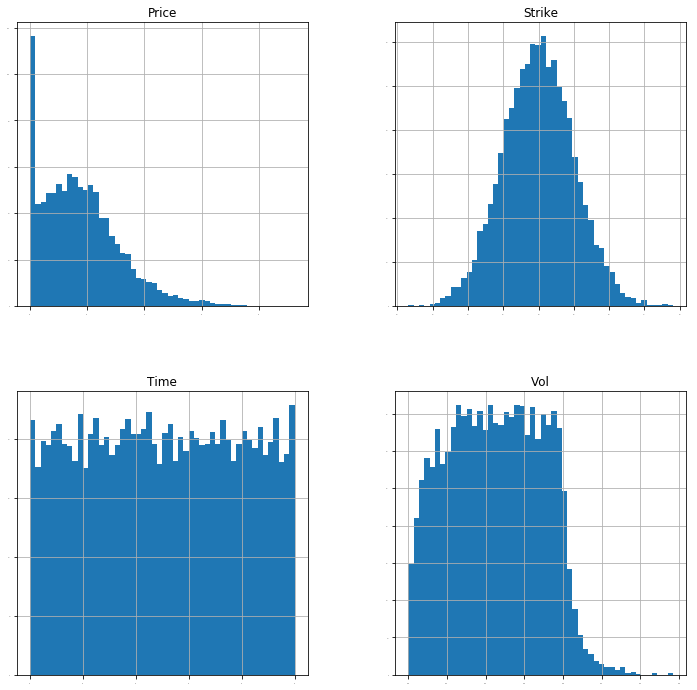

In [61]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

We can see that the price has an interesting distribution with a spike at $0$

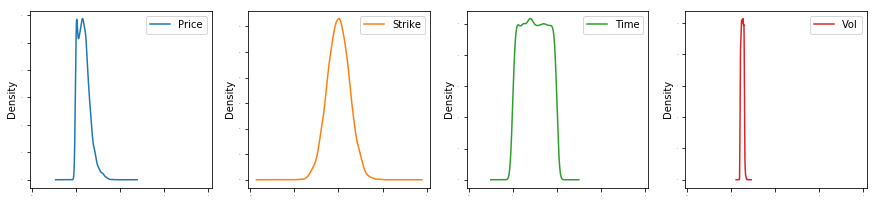

In [62]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

Next we look at the interaction between different variables

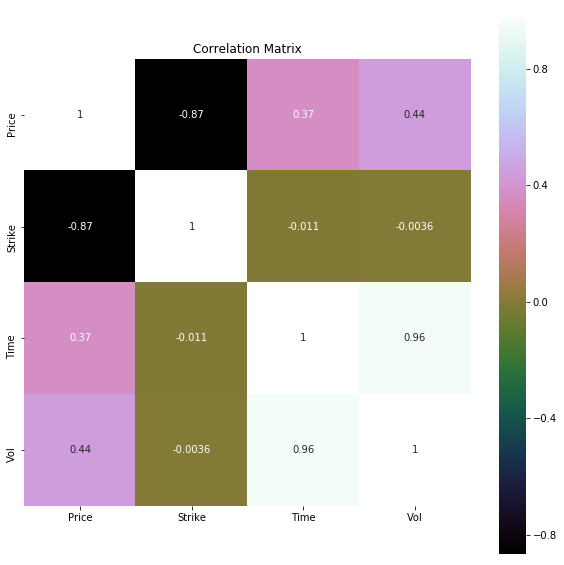

In [63]:
correlation = dataset.corr()
pyplot.figure(figsize=(10,10))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<Figure size 1080x1080 with 0 Axes>

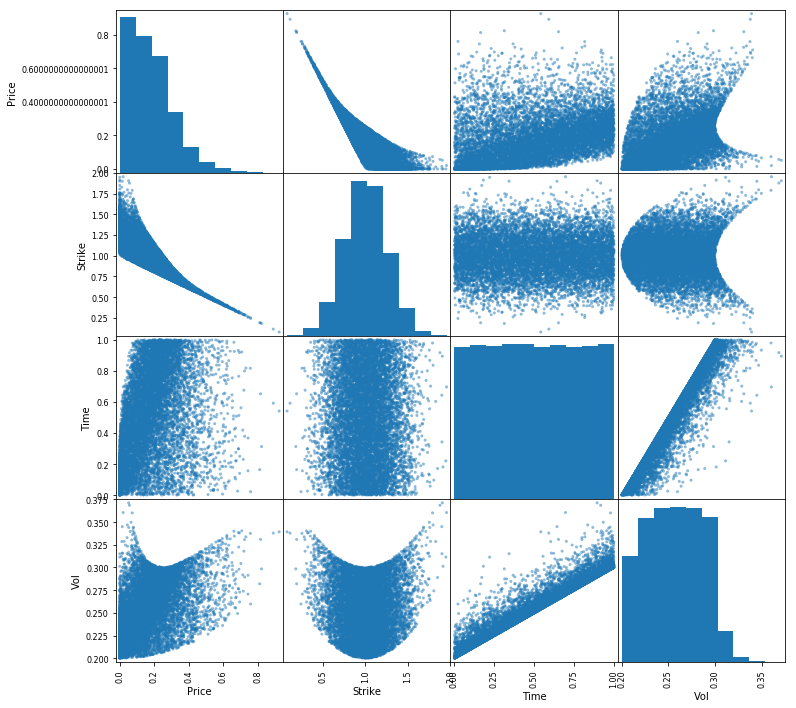

In [64]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

We see some very interesting non linear analysis. This means that we expect our non linear models to do a better job than our linear models

<a id='3'></a>
## 4. Data Preparation and Analysis

<a id='4.1'></a>
## 4.1. Univariate Feature Selection

We start by using a simple linear feature selection procedure.

In [65]:
bestfeatures = SelectKBest(k='all', score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(['Strike', 'Time', 'Vol'])
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
Strike,30282.309
Vol,2407.757
Time,1597.452


We observe that the strike is the most important variable for the price.

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split and Evaluation Metrics

In [66]:
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

We use the prebuilt scikit models to run a K fold analysis on our training data. We then train the model on the full training data and use it for prediction of the test data. The parameters for the K fold analysis are defined as -

In [67]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

<a id='4.2'></a>
## 5.2. Compare Models and Algorithms

#### Linear Models and Regression Trees

In [68]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

#### Neural Network Predictor

In [69]:
models.append(('MLP', MLPRegressor()))

#### Boosting and Bagging Methods

In [70]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [71]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, random_state=seed)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000359 (0.000024) 0.000359 0.000351
LASSO: 0.018281 (0.001112) 0.018277 0.017605
EN: 0.018281 (0.001112) 0.018277 0.017605
KNN: 0.000019 (0.000018) 0.000011 0.000015
CART: 0.000011 (0.000004) 0.000000 0.000009
SVR: 0.003342 (0.000555) 0.003512 0.003448
MLP: 0.000040 (0.000030) 0.000032 0.000032
ABR: 0.000667 (0.000041) 0.000663 0.000674
GBR: 0.000024 (0.000005) 0.000017 0.000022
RFR: 0.000005 (0.000005) 0.000001 0.000003
ETR: 0.000004 (0.000007) 0.000000 0.000001


We being by looking at the Kfold analysis

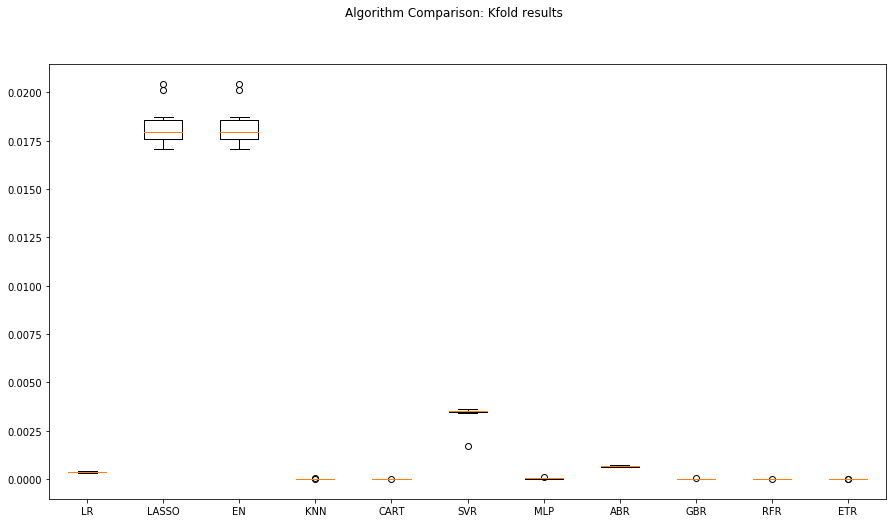

In [72]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

In order to get a better view, we remove the LASSO and Elastic Net

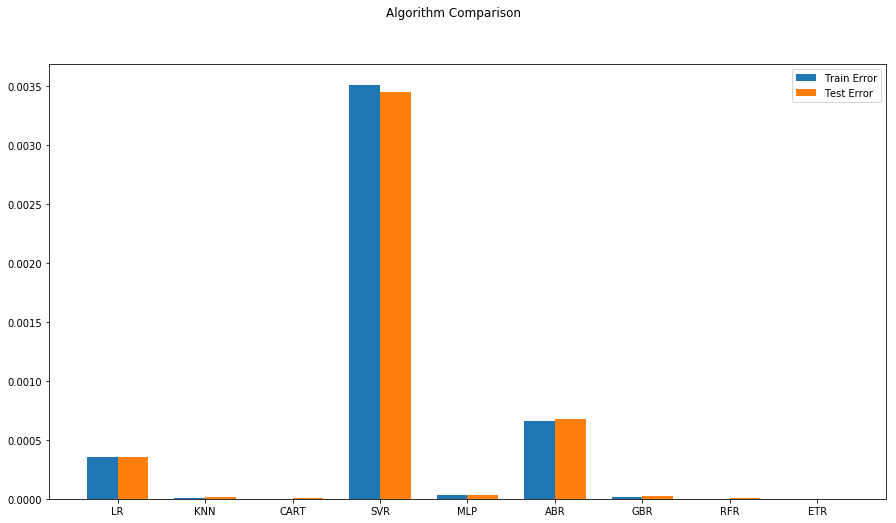

In [73]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names)-2)  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results[0:1] + train_results[3:],  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results[0:1] + test_results[3:], width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names[0:1] + names[3:])
pyplot.show()

We see that the multilayer perceptron (MLP) algorithm does a lot better that the linear algorithm. However, the Regression Trees and the Forest methods do a very good job as well. Given MLP is one of the best models we perform the grid search for MLP model in the next step.  

<a id='5'></a>
# 6. Model Tuning and finalising the model

As shown in the chart above the MLP model is one of the best model, so we perform the model tuning. We perform a grid search with different combination of hidden layers in the MLP model.  

In [74]:
'''
hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith
    hidden layer.
'''
param_grid={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 30, 20)]}
model = MLPRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000024 using {'hidden_layer_sizes': (20, 30, 20)}
-0.000580 (0.000601) with: {'hidden_layer_sizes': (20,)}
-0.000078 (0.000041) with: {'hidden_layer_sizes': (50,)}
-0.000090 (0.000140) with: {'hidden_layer_sizes': (20, 20)}
-0.000024 (0.000011) with: {'hidden_layer_sizes': (20, 30, 20)}


The best model is the model with 3 layers with 20, 30 and 20 nodes in each layer respectively. 

In [ ]:
# prepare model
model_tuned = MLPRegressor(hidden_layer_sizes=(20, 30, 20))
model_tuned.fit(X_train, Y_train)

In [ ]:
# estimate accuracy on validation set
# transform the validation dataset
predictions = model_tuned.predict(X_test)
print(mean_squared_error(Y_test, predictions))

We see that the mean error (RMSE) is  1.65e-5 , which is less than a cent. Hence, the deep learning model does an excellent job of fitting the Black-Scholes option pricing model. The accuracy may be enhanced with more tuning/

<a id='6'></a>
# 7. Additonal analysis: removing the volatilty data

Next, we make the process harder by trying to predict the price without the volatility data.

In [75]:
X = X[:, :2]

In [76]:
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

In [77]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

In [78]:
models = []
models.append(('LR', LinearRegression()))
#models.append(('LASSO', Lasso()))
#models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [79]:
models.append(('MLP', MLPRegressor()))

In [80]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [81]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, random_state=seed)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.002116 (0.000153) 0.002112 0.002194
KNN: 0.000019 (0.000018) 0.000011 0.000015
CART: 0.000011 (0.000004) 0.000000 0.000009
SVR: 0.003677 (0.000397) 0.003805 0.003721
MLP: 0.000040 (0.000019) 0.000125 0.000142
ABR: 0.000688 (0.000047) 0.000662 0.000666
GBR: 0.000025 (0.000005) 0.000018 0.000022
RFR: 0.000004 (0.000004) 0.000001 0.000002
ETR: 0.000003 (0.000005) 0.000000 0.000001


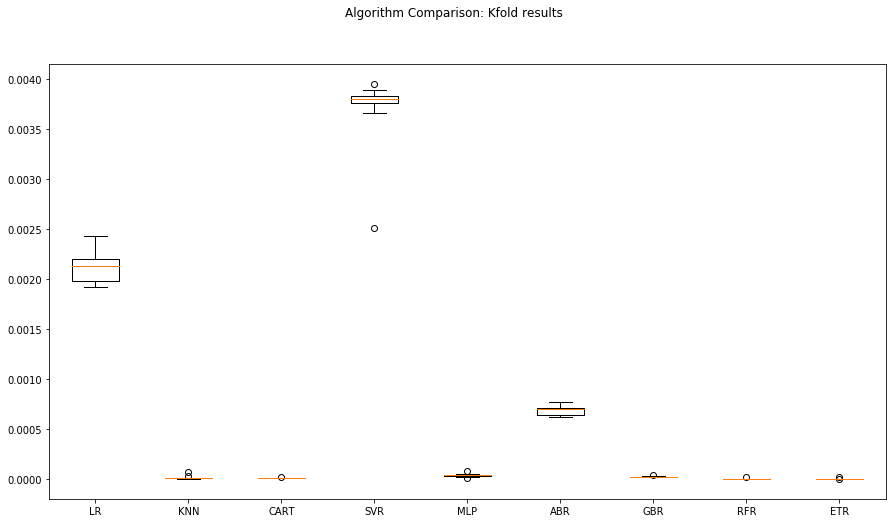

In [82]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

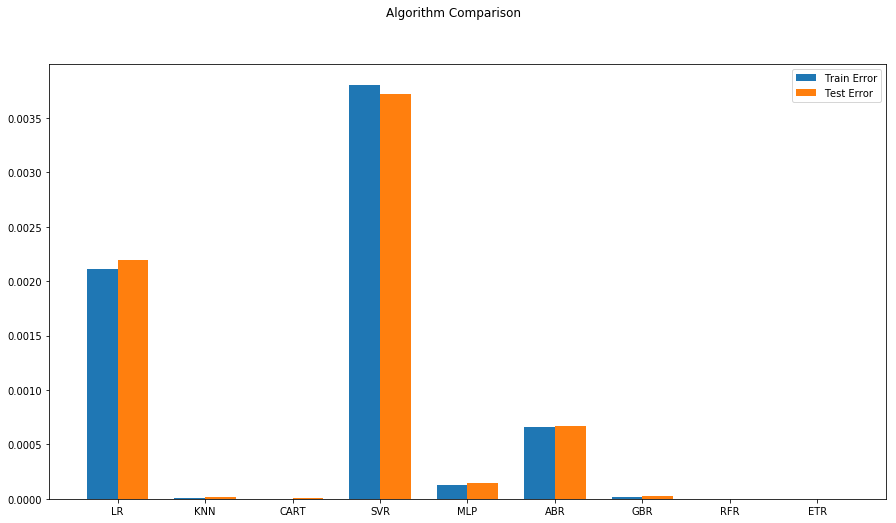

In [83]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

We can see that the linear regression now does a worse job than before, this is expected since we have added a greater amount of non linearity.

### Summary

* Overall the the non linear models are very accurate. The performance of the neural network model is good and it further increases when the model is tuned. 

* We know that option pricing is non linear problem. As expected, our linear regression model did not do as well as our non linear models.  We observe that Tree based regression models and the Random forests do a great job. 

* We also observe that removing the volatility increase the difficulty of the prediction problem for the linear regression. However, the tree regression and forest based methods are still able to do a very good job at the prediction process. This does indicate that one might be able to side step the development of a option vol surface.

* One important caveat is that our model has assumed a static model for the vol surface. In the real world, the vol surface can change on a day to day basis. This makes the limited number of data points available on a given date. One can assume a constant vol surface for a given time period in order to collect more data points.